# EDA

## Imports

### Packages

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%load_ext line_profiler

### Data import

In [3]:
# Import; parse string timestamp in datetime
# Convert datetime object in granular units for further analysis
df = pd.read_csv('data/load_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].apply(lambda dt: dt.year)
df['month'] = df['timestamp'].apply(lambda dt: dt.month)
df['dom'] = df['timestamp'].apply(lambda dt: dt.day)
df['weekday'] = df['timestamp'].apply(lambda dt: dt.weekday())
df['hour'] = df['timestamp'].apply(lambda dt: dt.hour)
#df['key'] = df.apply(build_cache_key, axis=1)

## Load Profiles

### Weekday profiles by year

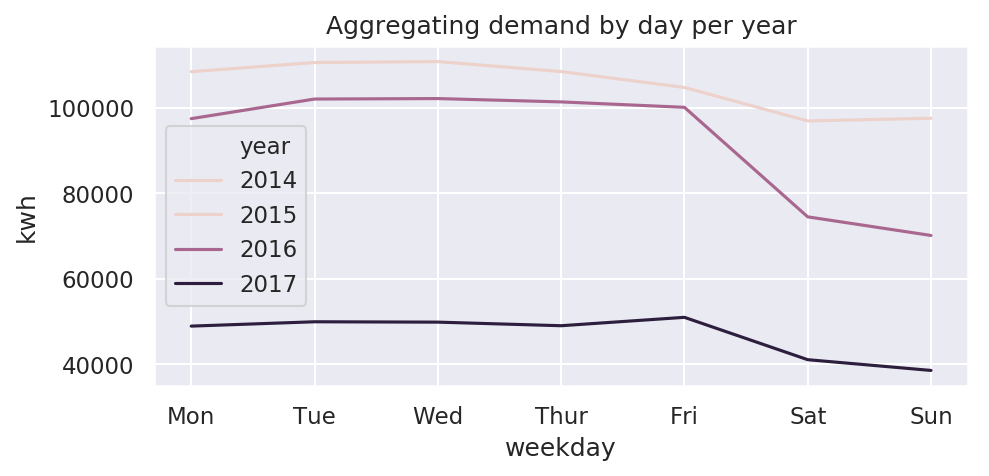

In [4]:
# Groupby by weekday; checking weekly profile across all months
# [0, 1, 2, ...] = [Monday, Tuesday, Wednesday, ...]
weekday_profiles = (df.groupby(['year', 'weekday'])['kwh'].sum()).reset_index()

# Plot settings
fig, ax = plt.subplots(figsize=(7,3),dpi=150)
ax.set_xticklabels(('', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
ax.set_title('Aggregating demand by day per year')

# Plot
sns.lineplot(x='weekday', y='kwh', hue='year', data=weekday_profiles, ax=ax);

Profile loads generally exhibit an increasing demand `Monday` through `Wednesday`. Demands began to decrease during `Thursday` and `Friday`. `Saturday` and `Sunday` see lowest values across all years. Optimization targets are weekdays. 

General profile would suggest commercial behavior. Assumed behavior of a residence would be lower consumption through the work week, while resident is at place of employment with higher values on the weekend when resident is more likely to be home.

### Hourly Profiles by day

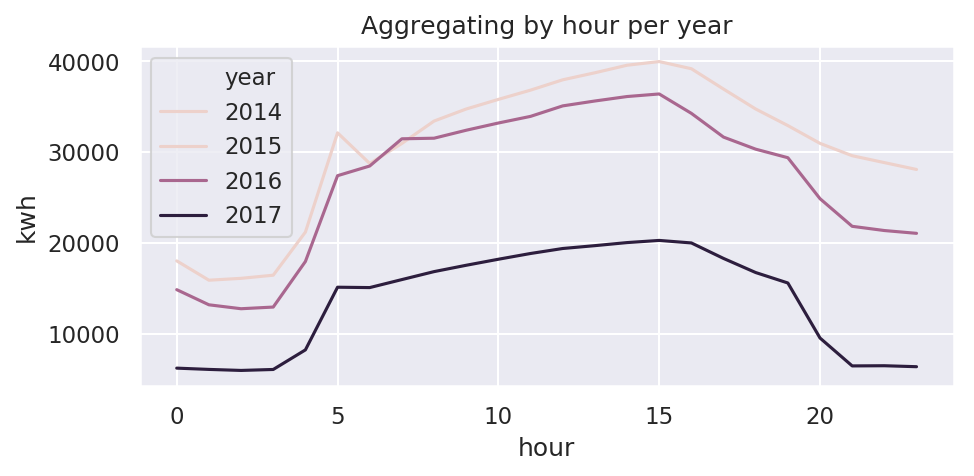

In [5]:
# Group by Year and hour; sum demand by hour
hourly_profiles = (df.groupby(['year', 'hour'])['kwh'].sum()).reset_index()

# Plot settings
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
ax.set_title('Aggregating by hour per year')

# Plot
sns.lineplot(x='hour', y='kwh', hue='year', data=hourly_profiles, ax=ax);

Aggregated hourly loads appear to support commercial assumption from daily aggregate profiles. Consumption begins to climb at 05:00 and peaks near 15:00. Profiles suggest early morning demand adjusting building climate and demands decreasing as both temperatures warm/cool and building is vacated.

### Monthly averages and standard deviation

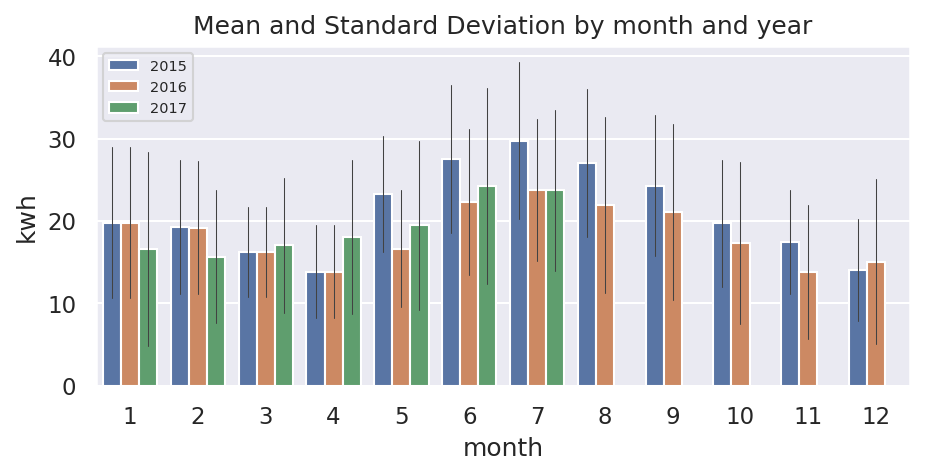

In [6]:
# Plot settings
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
ax.set_title('Mean and Standard Deviation by month and year')

# Plot
sns.barplot(x='month', y='kwh', hue='year', data=df, estimator=np.mean, ci='sd', errwidth=.5)
ax.legend(loc=2, fontsize='x-small');

Averaging the data by month with standard deviation displayed as uncertainty. General demand trend follows similar patter for all years. 2015 stands outs starting in May and extendng throughout the year.

## Closer look at peaks

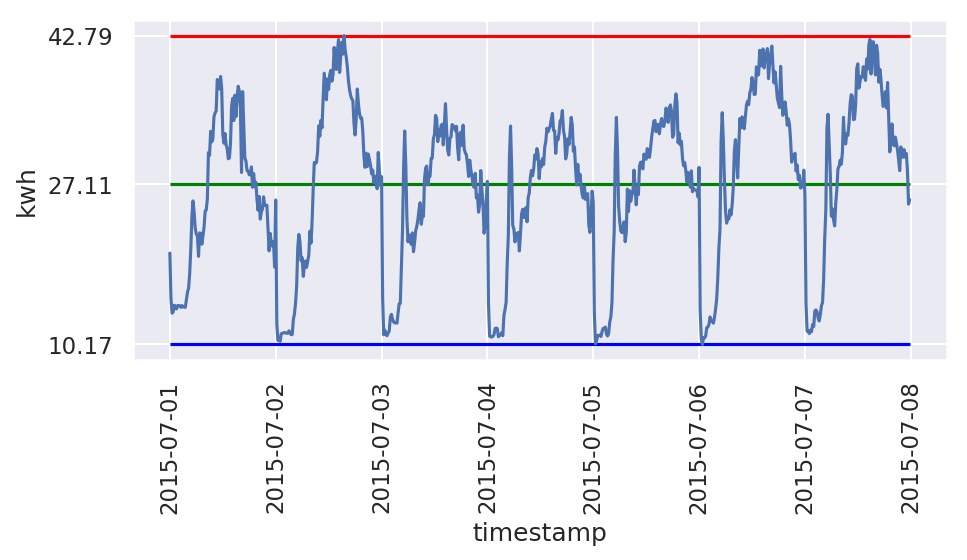

In [7]:
# July 2015; first week; highest average and usage
july15 = df[(df.year == 2015) & (df.month == 7)].copy()
july15['dom'] = july15['timestamp'].apply(lambda x: x.day)

# First week of July
firstWeekJuly = july15[july15.dom <= 7].copy()

# Add a threshold
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
sns.lineplot(x='timestamp', y='kwh', data=firstWeekJuly, ax=ax)

base_demand = firstWeekJuly.kwh.min()
peak_demand = firstWeekJuly.kwh.max()
mean_demand = firstWeekJuly.kwh.mean()
ax.hlines([base_demand, mean_demand, peak_demand], xmin=firstWeekJuly.timestamp.iloc[0], xmax=firstWeekJuly.timestamp.iloc[-1], color=['blue', 'green', 'red'])
ax.set_yticks([base_demand, mean_demand, peak_demand])

plt.xticks(rotation=90);

The chart represents the first week of July 2015. The three low peaks in the center represent Friday the 4th, Saturday the 5th and Sunday the 6th. If a single threshold is selected for the entire month, peak shaving impacts would be reduced compared to a smart daily dynamic shifts.

Each peak has a characteristic demand spike on the left side. A possible explanation is the building cooling cycle. Cooling demands are reduced at night when the building is not populated. To cool sufficiently before the workday begins, the cooling system must activate and operate near full capacity for a short interval. Once set temperature is reached, energy demands are reduced. As ambient temperatures rise, the systems cooling strives to maintain the building's internal temperature, resulting in the peak demand profile.

# Objective 1 - Peak Shaving

Peak shaving is the process of reducing energy demand peaks through various methods; one of those methods is battery storage. Batteries are set to charge when building demand drops below demand threshold. Once the building demand exceeds that threshold, batteries should discharge. Discharging reduces the energy demand of the building during the most expensive hours of the day.

Current battery strategy is a naive implementation. No considerations are made for inverter size, charge and discharge rates and battery degredation.

### Battery Strategy

A battery can assume an action $s_t$ based on building demand $D_t$, threshold $\tau$ and the state of charge $SoC_t$. The battery will discharge when the building demand exceeds the threshold and battery state of charge is nonzero. Charging occurs when the building demand is less than the threshold value and state of charge is not equal to battery maximum charge. Finally, standby is when building demand is below the threshold and battery is fully charged.
<br />

$$
S(B_t) = \begin{cases}
    \text{discharge} & D_t \geq \tau \land SoC_t > 0 \\
    \text{charge} & D_t < \tau \land SoC_t < SoC_{max} \\
    \text{standby} & D_t < \tau \land SoC_t = SoC_{max}
\end{cases}
$$

**_Discharge_**
<br />
In the discharge state, the battery will discharge energy equal to the difference between building demand and threshold. On the condition that the demand delta is greater than current state of charge $\Delta_t > B_t$, the battery strategy iteration will halt.  
<br/>
$$ 
\begin{align}
     \Delta_t &= D_t - \tau \\
     B_t &=  B_{t-1} - \Delta_t
\end{align}
$$
<br/>
An improvment that may increase battery longevity might be to limit discharge to a lower threshold for battery capacity.

**_Charge_**<br/>
In the charge state, the battery will draw power from the energy grid; increasing total building demand. Current battery charging strategy is to charge a fraction of the delta between building demand and threshold value. This extends the charge time but extends charge time into off peak hours.
<br/>
$$ 
\begin{align}
     \Delta_t &= D_t - \tau \\
     B_t &=  B_{t-1} + \Delta_t
\end{align}
$$
<br/>
An improvement to this method would be strictly limiting charge times to off-peak hours; $ t \in \mathbb{OP} $, where $\mathbb{OP}$ represents the set offpeak hours in battery's current energy market. Charging limits might also be created to increase longevity of battery. For instance, set optimal charge threshold between 85-90% of charge maximum.

**_Standby_**<br/>
In standby, no action is currently taken. An improvment could be made to measure the battery's self-discharge rate and enter a charge state if state of charge fell below a given charge threshold.

### Implementation

In [8]:
from peakshave.api.battery import Battery
from peakshave.api.environment import Environment
from peakshave.api.peakshave import daily_battery_strategy_threshold, compute_daily_threshold

In [9]:
# Count total days
total_days = sum(1 for _,_ in df.groupby(['year', 'month', 'dom']))
print('Total days in data set: {}'.format(total_days))

Total days in data set: 915


In [10]:
# Builds strategy for each day in dataset
shaved = df.groupby(['year', 'month', 'dom']).apply(daily_battery_strategy_threshold)
shaved = shaved.drop(columns=['year', 'month', 'dom']).reset_index()

/home/miles/miniconda3/envs/powerranger/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


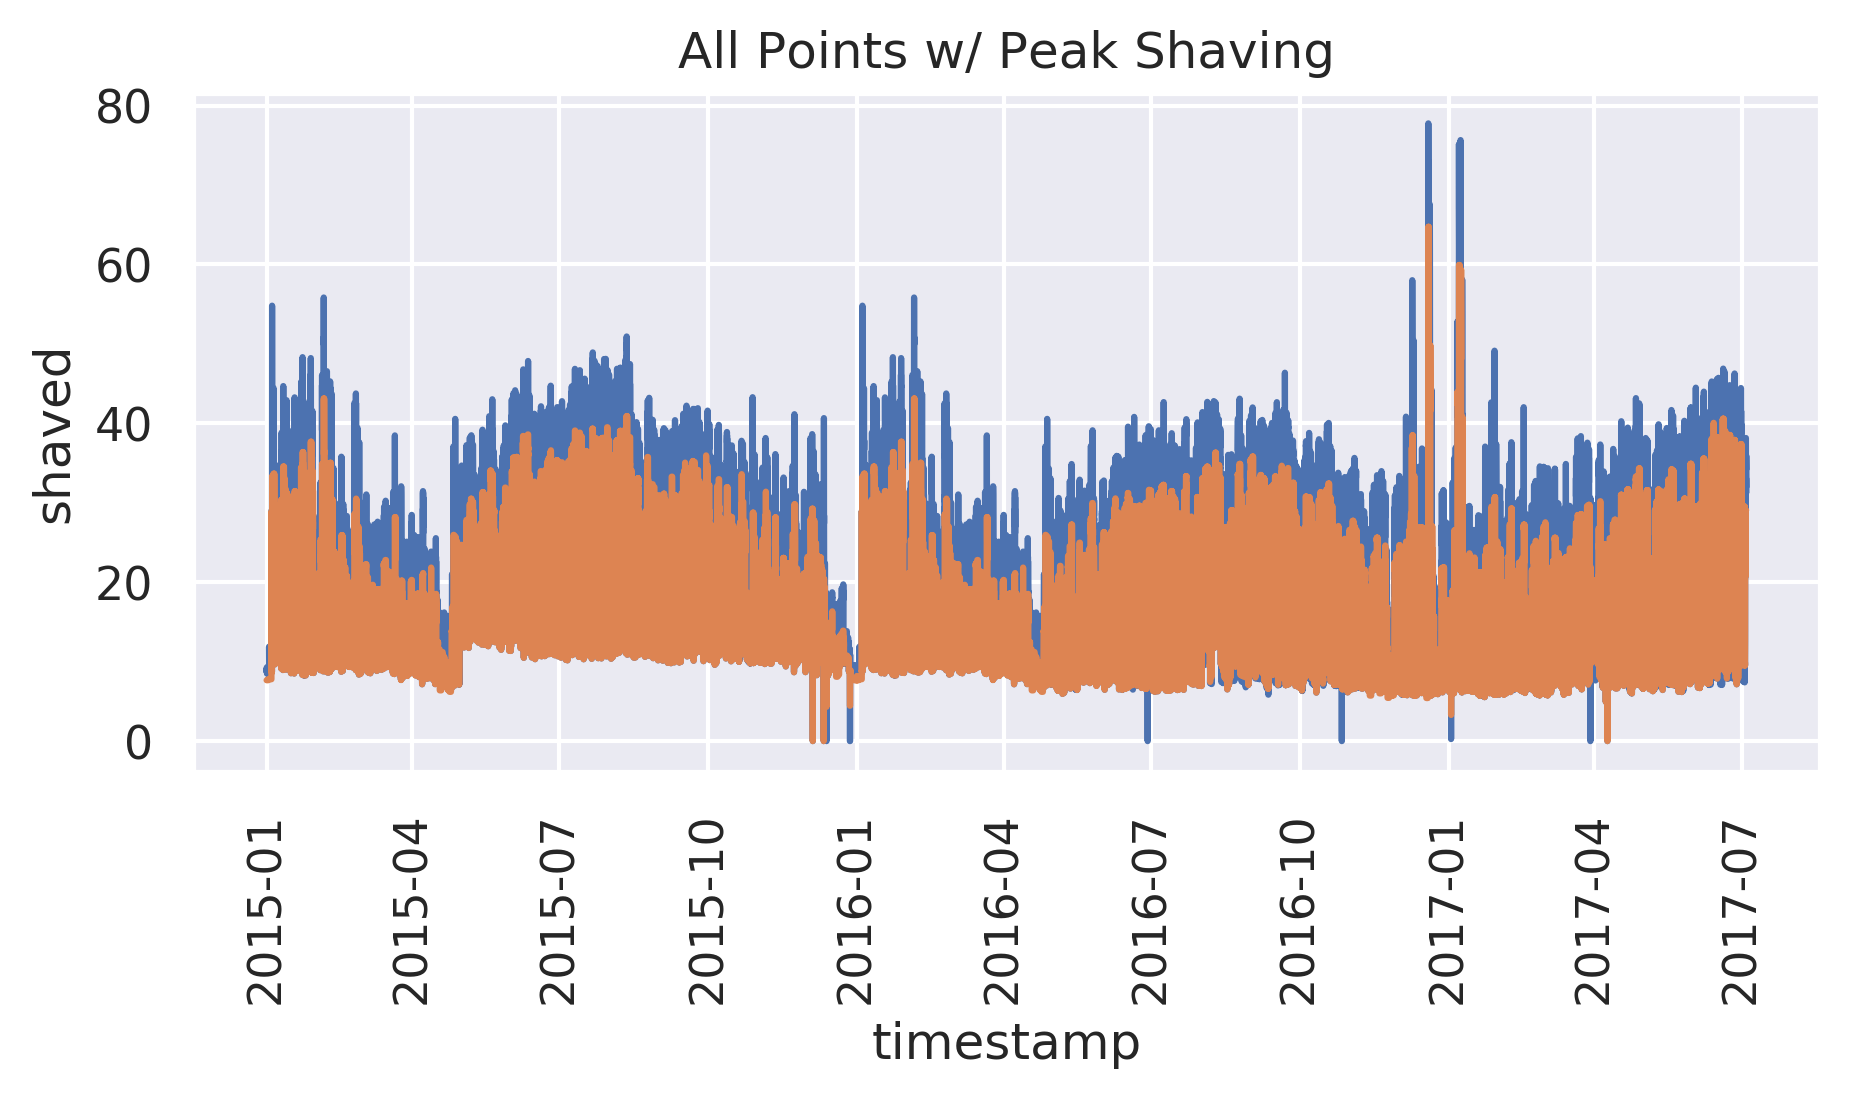

In [11]:
fig, ax = plt.subplots(figsize=(7,3), dpi=300)
sns.lineplot(x='timestamp', y='kwh', ax=ax, data=shaved)
sns.lineplot(x='timestamp', y='shaved', ax=ax, data=shaved)

ax.set_title('All Points w/ Peak Shaving')
plt.xticks(rotation=90);

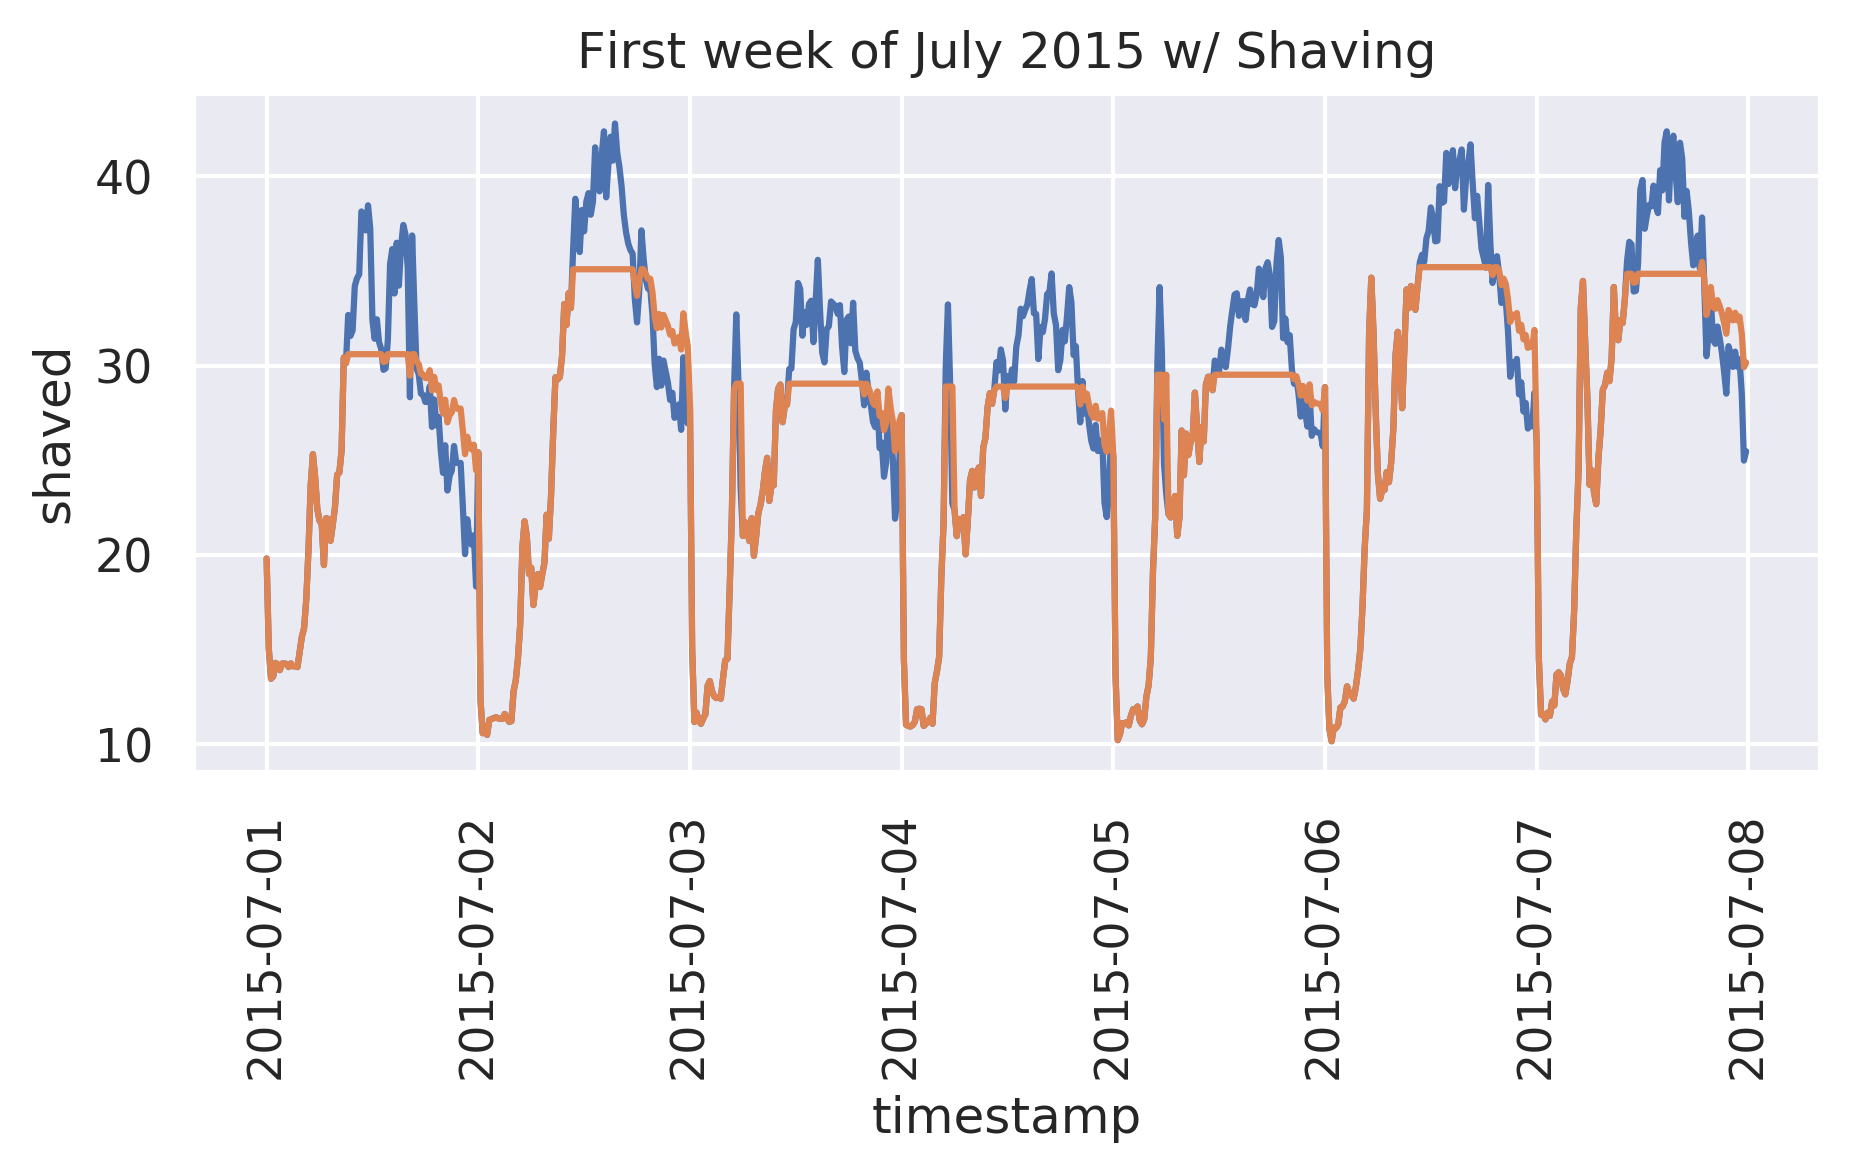

In [12]:
fig, ax = plt.subplots(figsize=(7,3), dpi=300)
july15 = shaved[(shaved.year == 2015) & (shaved.month == 7) & (shaved.dom < 8)]
sns.lineplot(x='timestamp', y='kwh', data=july15)
sns.lineplot(x='timestamp', y='shaved', data=july15)
ax.set_title('First week of July 2015 w/ Shaving')

plt.xticks(rotation=90);


What does the above chart show? Each day a unique threshold has been calculated that best smooths the peak to the threshold.

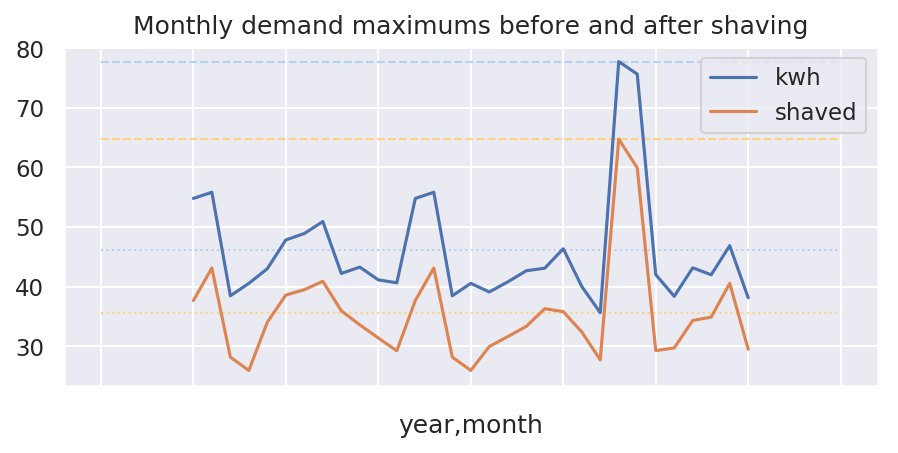

In [13]:
compare = shaved.groupby(['year', 'month'])[['kwh', 'shaved']].max()
compare['delta%'] = (compare.kwh - compare.shaved) / compare.kwh * 100.0

fig, ax = plt.subplots(figsize=(7,3), dpi=150)
compare.plot(kind='line', y=['kwh', 'shaved'], ax=ax)
ax.set_title('Monthly demand maximums before and after shaving')

xticks = ax.get_xticks()
xmin, xmax = xticks[0], xticks[-1]

# Montly maximums and median values
ax.hlines([compare.kwh.max(), compare.shaved.max(), compare.kwh.mean(), compare.shaved.mean()],
          xmin=xmin, xmax=xmax, 
          linestyle=['--', '--',':', ':'], linewidth=1, 
          colors=['#b3d2ee', '#ffd27f']);

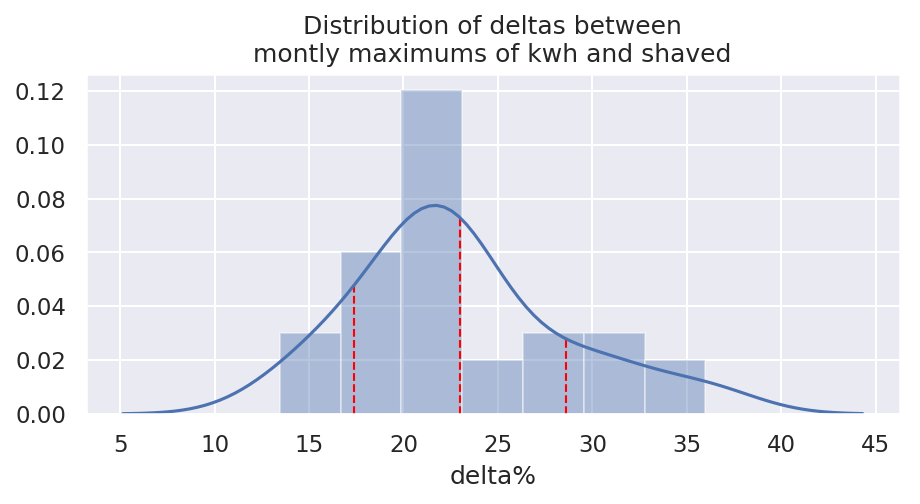

In [14]:
# Used to get vertical line height
def find_nearest(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()
    
# Arrays for plotting
mean_delta = compare['delta%'].mean()
std_delta = compare['delta%'].std()

# Create plot
fig, ax = plt.subplots(figsize=(7,3), dpi=150)
sns.distplot(compare['delta%'], ax=ax, norm_hist=True)

# Get heights from kde to plot mean, +/- sigma
orig, normalized = ax.get_lines()[0].get_data()
mean_height = normalized[find_nearest(orig, mean_delta)]
low_sigma = normalized[find_nearest(orig, mean_delta - std_delta)]
high_sigma = normalized[find_nearest(orig, mean_delta + std_delta)]

# Vertical lines
yticks = ax.get_yticks()
ymin, ymax = yticks[0], yticks[-1]
ax.vlines(mean_delta, ymin=ymin, ymax=mean_height, colors=['red'], linestyle='--', linewidth=1)
ax.vlines(mean_delta - std_delta, ymin=ymin, ymax=low_sigma, colors=['red'], linestyle='--', linewidth=1)
ax.vlines(mean_delta + std_delta, ymin=ymin, ymax=high_sigma, colors=['red'], linestyle='--', linewidth=1)

# Title
ax.set_title('Distribution of deltas between\nmontly maximums of kwh and shaved');

## Objective 1 - Threshold Selection Conclusion

Selection of a threshold per month results in missed cost saving opportunities under the assumptions of an ideal battery. Often times the maximum monthly demand is an outlier within that month. Setting daily values facilitates the further cost savings by reducing peak load on all days by discharging the battery throughout peak load times and charging in off-peak. 

Historic threshold optimization averaged approximately 23 +/- 6%. The lowest monthly gain was 13% and highest monthly gain 36%. The iterative approach in the solution guarantees convergence to a minimum daily threshold value. Similiar to Newton's method, the closer an initial threshold guess is to the daily optimum, the faster a solution. Unlike Newton's method, iteration occurs in a single direction (decreasing) and forces the threshold to reach the daily optimum or predifined minimum value; 1kwh.

**_Next Steps_**<br/>

_Code Optimization_<br/>
Current solution should be optimized by refactoring the daily strategy. Translation to vectorized numpy or tensorflow would likely see the largest reductions in runtime. 


_Adaptive Threshold Selection_<br/>
The current algorithm functions as a solution but is fragile; it does not adapt. Implementing a sequence based learning algorithm against the daily thresholds. The chart below shows potential dataflow through an adaptive system for optimizing realtime threshold selection.

![img](images/BatteryOptimization-Page-1.png)

# Objective 2 - Battery Capacity

In [15]:
from peakshave.api.peakshave import daily_battery_strategy_capacity
from peakshave.api.battery import Battery

In [16]:
# Builds strategy for each day in dataset
# Long running
shaved = df.groupby(['year', 'month', 'dom']).apply(daily_battery_strategy_capacity)
shaved = shaved.drop(columns=['year', 'month', 'dom']).reset_index()

In [17]:
daily_batt = shaved.groupby(['year', 'month', 'dom'])['battery']\
    .apply(lambda x: x.drop_duplicates())\
    .reset_index()

### Implementation

In [18]:
monthly_batt = daily_batt.groupby(['year', 'month'])['battery'].max().reset_index()

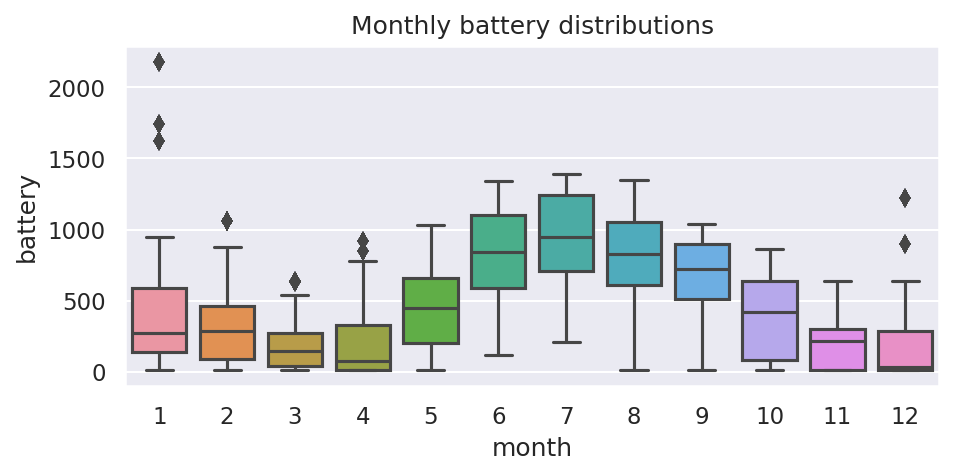

In [19]:
fig, ax = plt.subplots(figsize=(7,3), dpi=150)
sns.boxplot(x="month", y="battery", data=shaved, ax=ax)
ax.set_title('Monthly battery distributions');

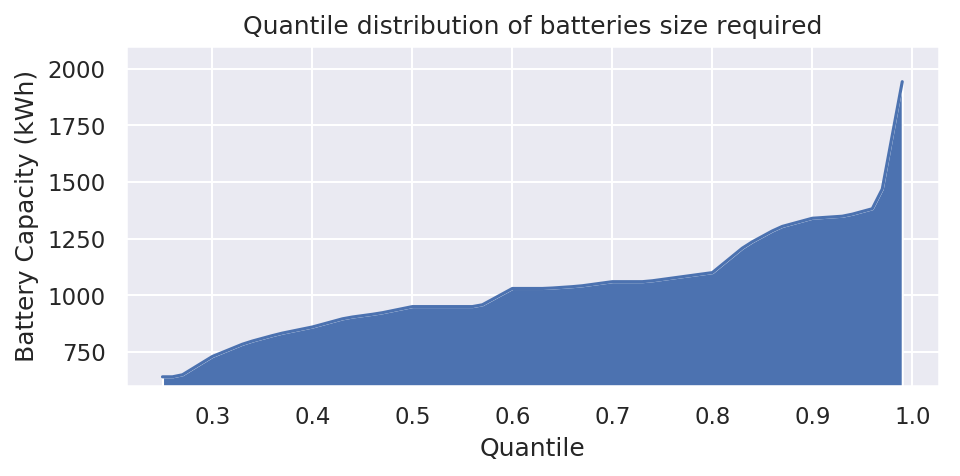

In [20]:
x = np.arange(0.25, 1.0, 0.01)
y = np.quantile(monthly_batt.battery, x)
fig, ax = plt.subplots(figsize=(7,3), dpi=150)
ax.plot(x, y)
ax.set_xlabel('Quantile')
ax.set_ylabel('Battery Capacity (kWh)')
ax.set_title('Quantile distribution of batteries size required')

ax.fill_between(x, y)
ax.set_ybound(lower=600, upper=2100)


The above distribution charts represents the quantiles of battery capacity by month. 80% of days within the days set can be maintained at the 18kWh threshold using a battery capacity of 1100. 95% of days can be covered with a battery capacity of 1375kWh.<br />

## Object 2 - Battery Capacity Conclusions

For the given data set, a battery with capacity of 2180kWh is required to maintain a constant demand threshold of 18kWh. Although this battery has the ability to maintian the constant demand threshold it's capacity exceeds the majority of maximum demands throughout the 915 days within the dayset. 95% of days (870) can be covered with a battery with 1375kWh capacity; only 63% of the 2180kWh capacity.

# References

Kutkut, N. Energy Management through Peak Shaving and Demand Response. Energy Management through Peak Shaving and Demand Response Available at: https://act-chargers.com/wp-content/uploads/2017/03/ACT-White-Paper-Energy-Management-through-Peak-Shaving-and-Demand-Response.pdf.

Karmiris, G., Tengner, T. Peak Shaving Control Method for Energy Storage. Available at: https://www.sandia.gov/ess-ssl/EESAT/2013_papers/Peak_Shaving_Control_Method_for_Energy_Storage.pdf

Yuanyuan Shi, B., Bolun Xu, D., Zhang, B. Using Battery Storage for Peak Shaving and Frequency Regulation: Join Optimization for Superlinear Gains: Available at https://arxiv.org/pdf/1702.08065.pdf